Data Challenge를 하는 경우,
  - Training set의 X, Y만 제공하고 Test set에서는 X만 제공함
  - 예측하는 H를 빌드업하고 Data Challenge Site에 보내서 점수를 매김

--> Training Set을 또 Training과 Validation set으로 나눠서 그래프를 보면서 Overfitig이 일어 나는지 보고 Early stop을 하는 등의 해결방법을 써서 주도적으로 확인할 수 있음

In [ ]:
!pip install -q torch torchvision
import torch
print(torch.__version__)

1.7.0+cu101


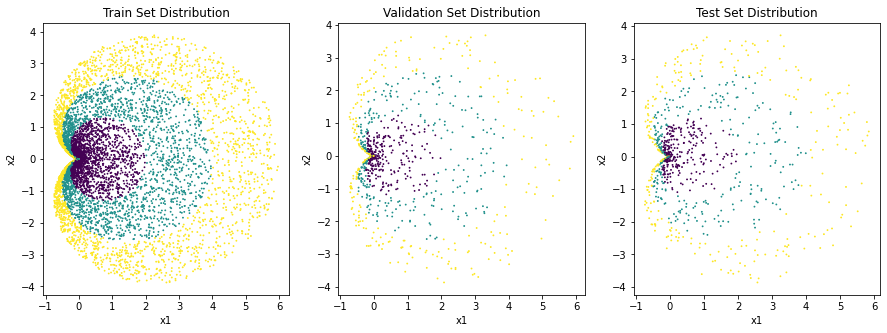

In [ ]:
# 1. Data Generation
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Generating Dataset
r = np.random.rand(10000)*3
theta = np.random.rand(10000)*2*np.pi
y = r.astype(int)     # int로 type을 바꿔서 정수형으로 바꿈 
r = r*(np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# Split Dataset into Train, Validation, Test
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# Visualize Each Dataset
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7) # c=class를 나눠주기 위한 파라미터, s=점의 size를 정의하는 파라미터
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y, s=0.7)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y, s=0.7)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()


In [ ]:
# 2.Hypothesis Define(Model Define)
import torch
import torch.nn as nn

class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.linear = nn.Linear(in_features=2, out_features=3, bias=True)
    self.softmax = nn.Softmax()

  def forward(self, x):
    x = self.linear(x)
    x = self.softmax(x)   # softmax의 유무가 Linear와 Classification의 차이
    return x

class MLPModel(nn.Module):
  def __init__(self):
    super(MLPModel, self).__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=200)
    self.linear2 = nn.Linear(in_features=200, out_features=3)   # out_features가 왜 3인가
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    return x


In [ ]:
# 3. Cost Function Define(Loss Function Define)
'''
 Pytoch Docs를 보면 CrossEntropyLoss는 이미 Softmax 기능이 포함되어 있어서 모델링할때 
 Softmax를 넣으면 두 번 하는 것이므로 제대로 Train을 하는 것이 아니게 됨.
'''
cls_loss = nn.CrossEntropyLoss()    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html


# test_pred_y = torch.Tensor([[2, 0.1], [0, 1]])
# test_true_y1 = torch.Tensor([1,0]).long()   # 정수형으로 몇 번째 값인지를 표시해야함
# test_true_y2 = torch.Tensor([0, 1]).long()  # 각 파라미터 마다 요구하는 type값을 잘 숙지해야함

# print(cls_loss(test_pred_y, test_true_y1))
# print(cls_loss(test_pred_y, test_true_y2))

In [ ]:
# 4. Train&Evaluation
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Construct Model
# model = LinearModel()
# print(model.linear.weight)
# print(model.linear.bias)

model = MLPModel()
# report할 때 parameter 수를 기재해야할 경우를 위한 편의상의 코드
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# Construct Optimizer
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만듦
list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 4000
for i in range(epoch):
  # Train
  model.train()
  optimizer.zero_grad()

  input_x = torch.Tensor(train_X)
  true_y = torch.Tensor(train_y).long()
  # true_y = torch.Tensor(train_y).item()
  pred_y = model(input_x)
  # print(input_x.shape, true_y.shape, pred_y.shape)  # 각 input과 output 차원 체크

  loss = cls_loss(pred_y.squeeze(), true_y)
  loss.backward()
  optimizer.step()
  list_epoch.append(i)
  list_train_loss.append(loss.detach().numpy())

  # Validation
  model.eval()
  optimizer.zero_grad()
  input_x = torch.Tensor(val_X)
  true_y = torch.Tensor(val_y).long()
  pred_y = model(input_x)
  loss = cls_loss(pred_y.squeeze(), true_y)
  list_val_loss.append(loss.detach().numpy())

  # Evaluation
  if i % 200 == 0:  # 200회 학습마다 실제 데이터 ㅂㄴ포와 모델이 예측한 분포 그리기
    # Calculate Accuracy
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(test_X)
    true_y = torch.Tensor(test_y)   # 모르고 train_y를 넣어서 한참 찾았네;
    pred_y = model(input_x).detach().max(dim=1)[1].numpy()
    acc = accuracy_score(true_y, pred_y)
    list_acc.append(acc)
    list_acc_epoch.append(i)

    fig = plt.figure(figsize=(15, 5))

    # True Y Scattering
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_title('True test y')

    # Predicted Y Scattering
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_title('Predicted test y')
    
    # Just for Visualizaing with High Resolution
    input_x = torch.Tensor(train_X)
    pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
    ax3.set_xlabel('x1')
    ax3.set_ylabel('x2')
    ax3.set_title('Prediction on train set')

    plt.show()
    print('Epoch: ', i,  'Accuracy: ', acc*100, '%')





Output hidden; open in https://colab.research.google.com to view.

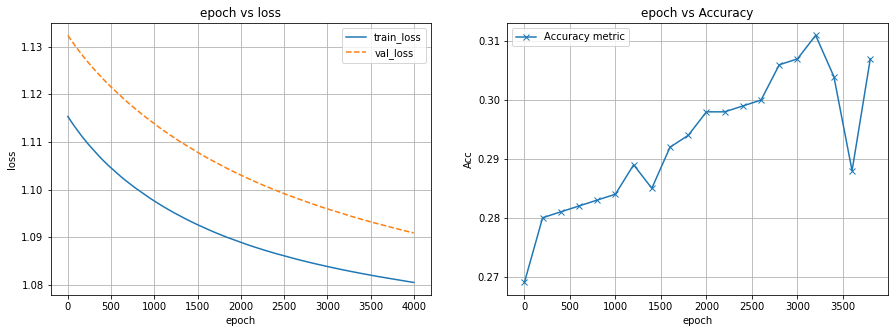

In [ ]:
# 5. Report Experiment
fig = plt.figure(figsize=(15,5))

# Loss Fluctuation
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# Metric Fluctuation
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()